<h2 style='color:blue'>Feature Engineering</h2>

**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [33]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 

In [34]:
df3 =pd.read_csv(r"C:\Users\pj\Downloads\Bangalore House Price Prediction\data\Processed_data\Data_Analysis.csv")

**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [35]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [36]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None   

In [37]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4


**Add new feature called price per square feet**

In [38]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [39]:
df5.to_csv(r'C:\Users\pj\Downloads\Bangalore House Price Prediction\data\Processed_data\bhp.csv', index=False)

**Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations**

In [40]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: location, Length: 1287, dtype: int64

In [41]:
location_stats.values.sum()

13200

In [42]:
len(location_stats[location_stats>10])

240

In [43]:
len(location_stats)

1287

<h2 style="color:blue">Dimensionality Reduction</h2>

**Any location having less than 10 data points will be tagged as "other" location. This way number of categories can be reduced by huge amount. It will help us with having fewer dummy columns**

In [44]:
location_stats_less_than_10 = location_stats[location_stats<=10]

In [45]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

241

<h2 style="color:blue">Outlier Removal Using Logic</h2>

**Normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. Example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [46]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
57,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
67,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
69,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [47]:
df5.shape

(13200, 7)

In [48]:
df5.price_per_sqft.describe()

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

**Here we find that min price per sqft is 267 rs/sqft whereas max is 176470, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

In [49]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df6 = remove_pps_outliers(df5)
df6.shape

(11434, 7)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

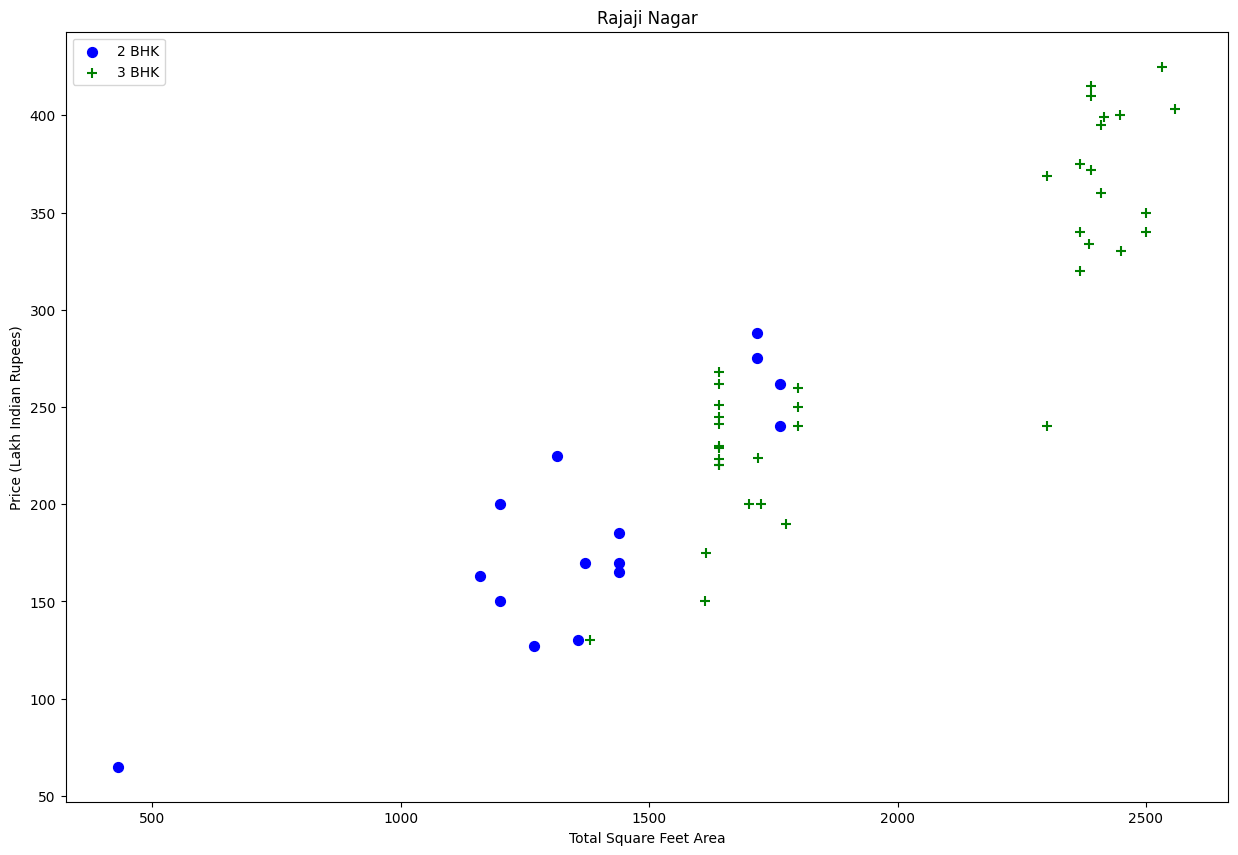

In [50]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df6,"Rajaji Nagar")
plt.savefig('C:/Users/pj/Downloads/Bangalore House Price Prediction/reports/visualization/2_3_BHK_plot.png')

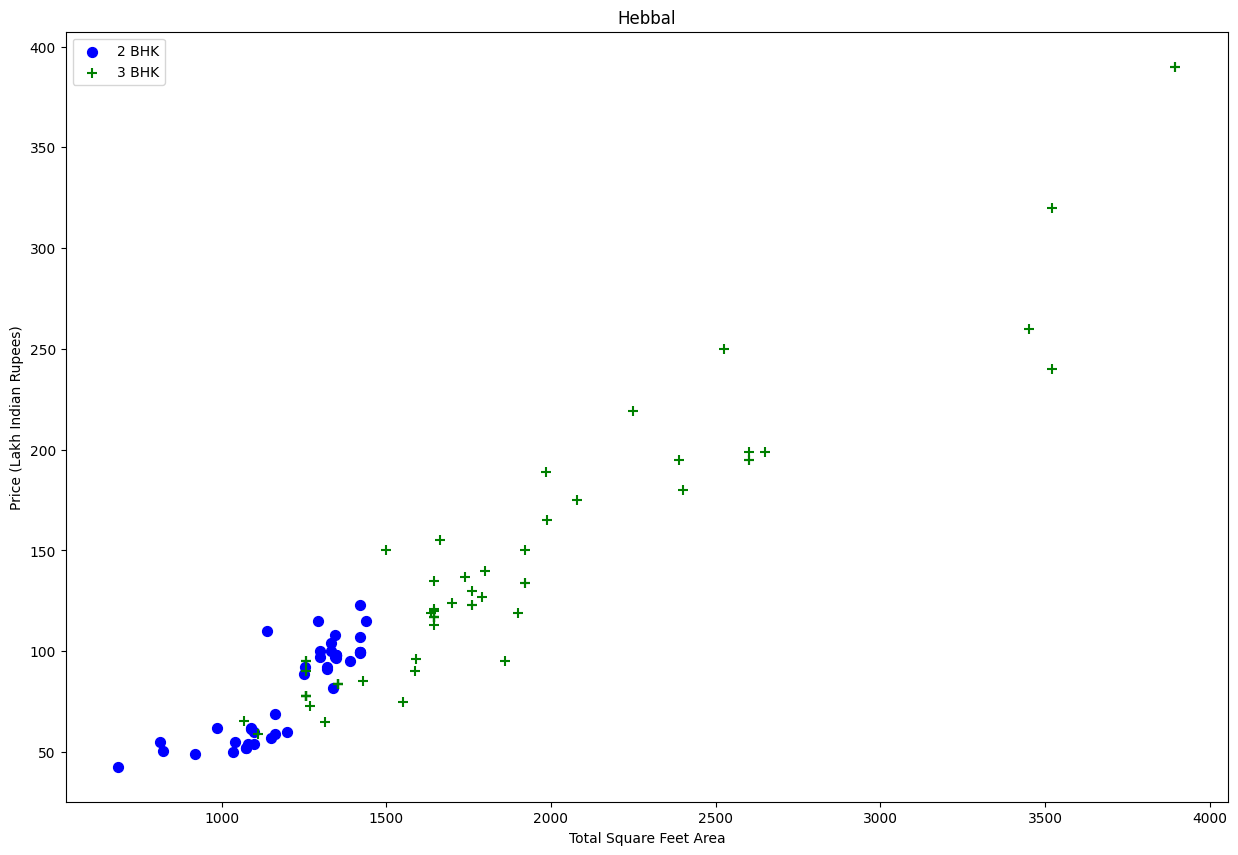

In [51]:
plot_scatter_chart(df6,"Hebbal")

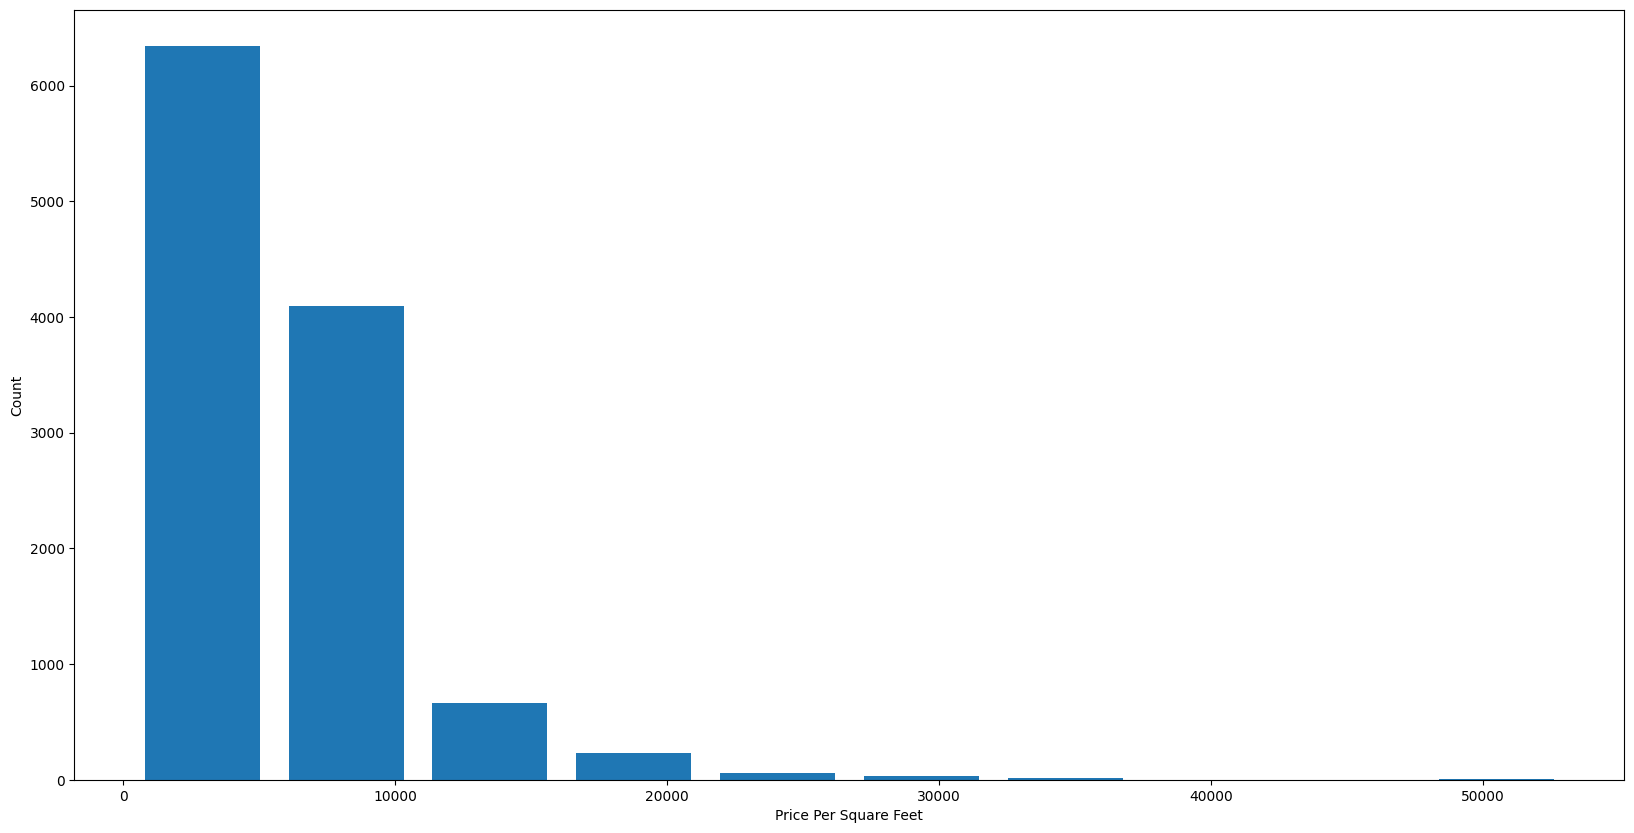

In [52]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df6.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")
plt.savefig('C:/Users/pj/Downloads/Bangalore House Price Prediction/reports/visualization/Per_SQ_Feet_plot.png')

<h2 style='color:blue'>Outlier Removal Using Bathrooms Feature</h2>

In [53]:
df6.bath.unique()

array([ 4.,  3.,  6.,  2.,  5.,  8.,  1.,  7.,  9., 10., 12., 14., 27.,
       11., 16., 15., 13., 18.])

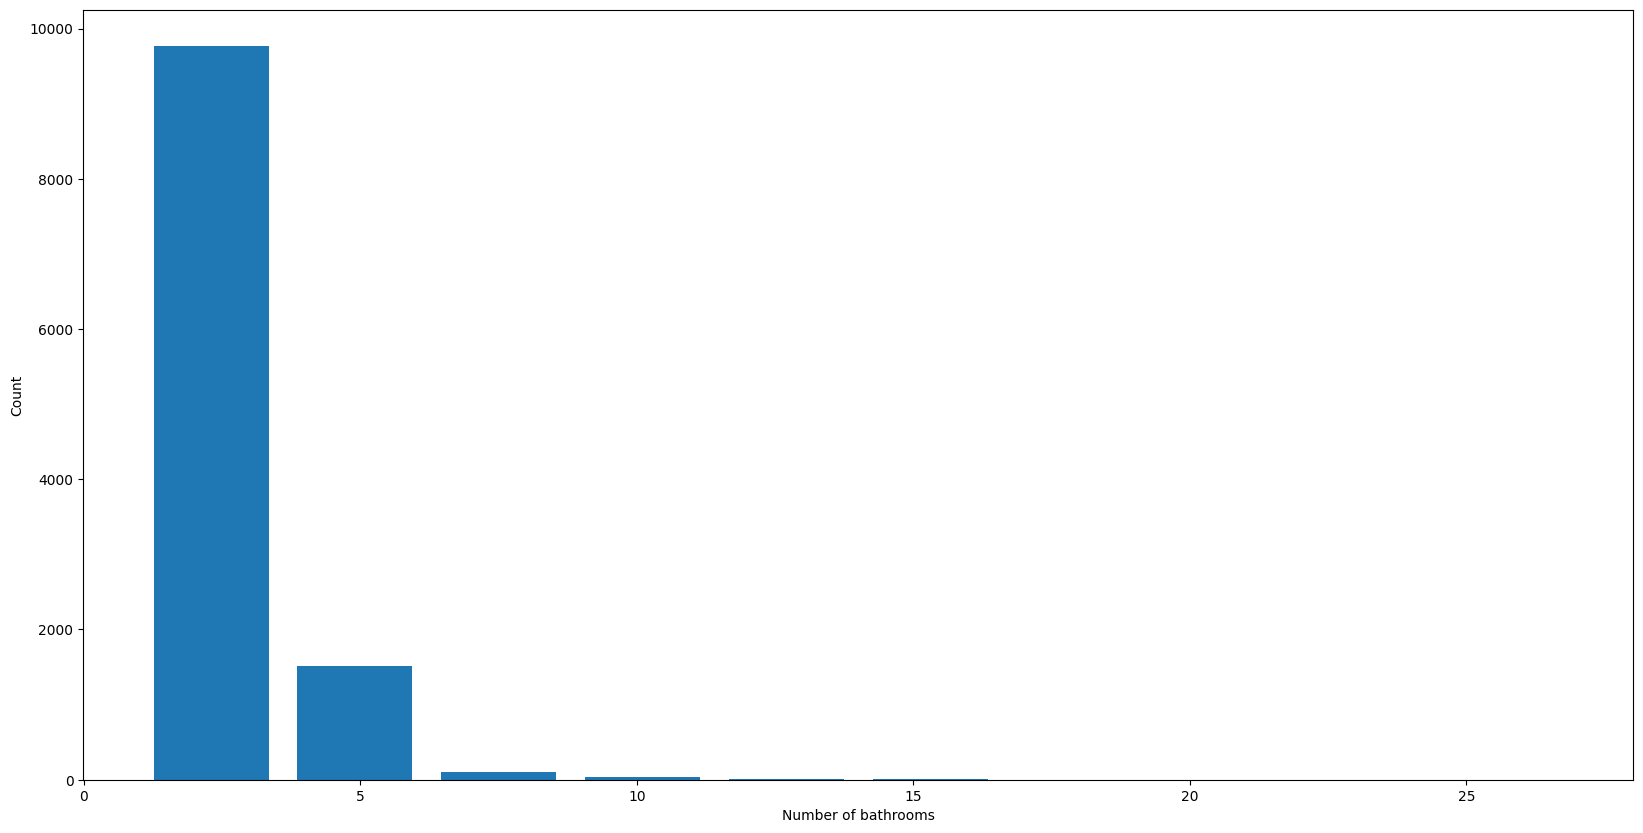

In [54]:
plt.hist(df6.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")
plt.savefig('C:/Users/pj/Downloads/Bangalore House Price Prediction/reports/visualization/No_Bathroom_plot.png')

In [55]:
df6[df6.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5645,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8808,other,9 Bedroom,3300.0,14.0,500.0,9,15151.515152
8942,other,27 BHK,8000.0,27.0,230.0,27,2875.000000
8952,other,11 Bedroom,1200.0,11.0,170.0,11,14166.666667
9003,other,8 Bedroom,990.0,12.0,120.0,8,12121.212121
9235,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
9291,other,19 BHK,2000.0,16.0,490.0,19,24500.000000
9344,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9629,other,14 BHK,1250.0,15.0,125.0,14,10000.000000
10280,other,11 BHK,6000.0,12.0,150.0,11,2500.000000


**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [56]:
df6[df6.bath>df6.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1635,Chamrajpet,6 Bedroom,1500.0,9.0,230.0,6,15333.333333
1771,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5604,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
7229,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8808,other,9 Bedroom,3300.0,14.0,500.0,9,15151.515152
9003,other,8 Bedroom,990.0,12.0,120.0,8,12121.212121
9146,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689
10308,other,8 Bedroom,1850.0,12.0,300.0,8,16216.216216
10693,other,3 Bedroom,2400.0,6.0,775.0,3,32291.666667
10700,other,6 Bedroom,1200.0,9.0,122.0,6,10166.666667


In [57]:
df7 = df6[df6.bath<df6.bhk+2]
df7.shape

(11307, 7)

In [58]:
df8 = df7.drop(['size','price_per_sqft'],axis='columns')
df8.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1200.0,6.0,125.0,6


<h2 style='color:blue'>Use One Hot Encoding For Location</h2>

In [59]:
dummies = pd.get_dummies(df8.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
df9 = pd.concat([df8,dummies.drop('other',axis='columns')],axis='columns')
df9.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1200.0,6.0,125.0,6,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,930.0,4.0,85.0,7,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
df10 = df9.drop('location',axis='columns')

In [62]:
df10

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.00,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.00,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1200.0,6.0,125.00,6,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1875.0,2.0,235.00,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,930.0,4.0,85.00,7,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11429,812.0,1.0,26.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11430,1440.0,2.0,63.93,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11431,1075.0,2.0,48.00,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11432,1200.0,5.0,325.00,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
df10.to_csv(r'C:\Users\pj\Downloads\Bangalore House Price Prediction\data\Processed_data\onehotdata.csv', index=False)